In [82]:
import grewpy
import yaml
import sys
import numpy as np

sys.path.insert(1, '/Users/madalina/Documents/M2TAL/stage/grex/grex2')
import pyximport
pyximport.install()
import grex.data
import grex.utils
import grex.features

In [83]:
path = "/Users/madalina/Documents/M1TAL/stage-SK/Treebanks/UD_French-GSD-master"
grewpy.set_config('ud')
corpus = grewpy.Corpus(path)
draft = grewpy.CorpusDraft(corpus)

In [4]:
matches = corpus.search(grewpy.Request("X[upos=ADV]"), clustering_parameter=['X.lemma'])

In [5]:
print(len(matches))

549


In [11]:
print(matches)

{'évidemment': [{'sent_id': 'fr-ud-train_11439', 'matching': {'nodes': {'X': '48'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_11129', 'matching': {'nodes': {'X': '6'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_08571', 'matching': {'nodes': {'X': '1'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_07285', 'matching': {'nodes': {'X': '6'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_07014', 'matching': {'nodes': {'X': '29'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_05178', 'matching': {'nodes': {'X': '6'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_02052', 'matching': {'nodes': {'X': '3'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_00061', 'matching': {'nodes': {'X': '2'}, 'edges': {}}}, {'sent_id': 'fr-ud-dev_01157', 'matching': {'nodes': {'X': '17'}, 'edges': {}}}, {'sent_id': 'fr-ud-dev_00055', 'matching': {'nodes': {'X': '4'}, 'edges': {}}}], 'éventuellement': [{'sent_id': 'fr-ud-train_14308', 'matching': {'nodes': {'X': '4'}, 'edges': {}}}, {'sent_id': 'fr-ud-train_11424', 'matching': {'nodes': {'X': '1

In [8]:
# The search space is defined using the yml file.
with open("patterns_adv.txt") as instream:
    config = yaml.load(instream, Loader=yaml.Loader)

templates = grex.utils.FeaturePredicate.from_config(config["templates"])
feature_predicate = grex.utils.FeaturePredicate.from_config(config["features"], templates=templates)

In [100]:
data = { k : list() for k in matches }
for adv, mts in matches.items():
    for match in mts:
        features = grex.data.extract_features(draft, match, feature_predicate)
        formatted_features = [
            f"{':'.join(k)}={v}" if not isinstance(v, set) else
            f"{':'.join(k)}={val}" for k, v in features.items() for val in (v if isinstance(v, set) else [v])
        ]
        data[adv].append(formatted_features)


In [13]:
print(data)

{'évidemment': [['node:X:own:rel_shallow=advmod', 'node:X:parent:position=after', 'node:X:parent:Gender=Masc', 'node:X:parent:Number=Sing', 'node:X:parent:upos=NOUN', 'node:X:child:upos=ADV', 'node:X:child:rel_shallow=advmod'], ['node:X:own:rel_shallow=advmod', 'node:X:parent:position=before', 'node:X:parent:Mood=Ind', 'node:X:parent:Number=Sing', 'node:X:parent:Person=3', 'node:X:parent:Tense=Pres', 'node:X:parent:VerbForm=Fin', 'node:X:parent:upos=VERB'], ['node:X:own:rel_shallow=advmod', 'node:X:parent:position=after', 'node:X:parent:Mood=Ind', 'node:X:parent:Number=Sing', 'node:X:parent:Person=3', 'node:X:parent:Tense=Pres', 'node:X:parent:VerbForm=Fin', 'node:X:parent:upos=VERB', 'node:X:child:upos=PUNCT', 'node:X:child:rel_shallow=punct'], ['node:X:own:rel_shallow=advmod', 'node:X:parent:position=before', 'node:X:parent:Mood=Ind', 'node:X:parent:Number=Sing', 'node:X:parent:Person=3', 'node:X:parent:Tense=Pres', 'node:X:parent:VerbForm=Fin', 'node:X:parent:upos=VERB'], ['node:X:o

In [101]:
unique_adv = sorted(set([k for k in data]))
unique_features = sorted(set([feat for _, matches in data.items() for m in matches for feat in m]))

idx2feature = {i : feat for i, feat in enumerate(unique_features) }
feature2idx = {feat : i for i, feat in idx2feature.items()}
idx2adv = {i : feat for i, feat in enumerate(unique_adv) }
adv2idx = {feat : i for i, feat in idx2adv.items()}

In [20]:
# Binary matrix, where the lines are the lemmas, features the columns, and values 0/1 indicating the presence of the feature for a given upos.
X = np.zeros((len(data.keys()), len(unique_features)))
for adv, samples in data.items():
    for m in samples:
        for feature in m:
            X[adv2idx[adv], feature2idx[feature]] = 1
print(f"{X.shape=}")

X.shape=(549, 211)


In [102]:
X = np.zeros((len(data.keys()), len(unique_features)))
for adv, samples in data.items():
    n_samples = len(matches)
    for m in samples:
        for feature in m:
            X[adv2idx[adv], feature2idx[feature]] += 1
    X[adv2idx[adv]] = X[adv2idx[adv]] / n_samples
print(f"{X.shape=}")

X.shape=(549, 211)


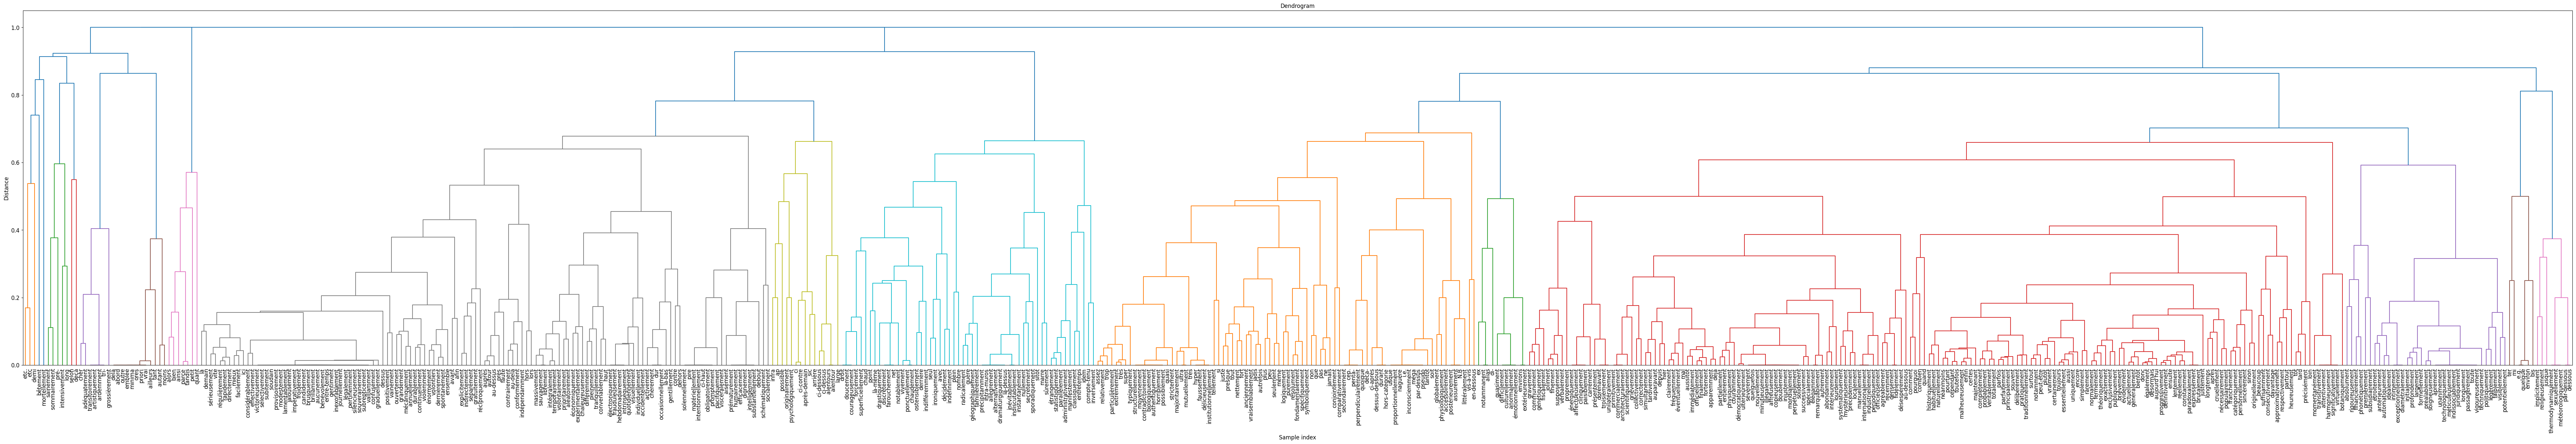

In [32]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
import matplotlib.pyplot as plt

# Hamming or jacard for categorical data, cosine for sparse matrices (normally used in NLP)
# I compute the distance for each pair of lines, each POS
distance_matrix = pdist(X, metric='cosine')
# Complete -> we cluster 
linked = linkage(distance_matrix, method="complete", optimal_ordering=True)

plt.figure(figsize=(100, 14))

dn = dendrogram(linked,
                orientation='top',
                labels=[name for name in unique_adv],
                distance_sort='descending',
                show_leaf_counts=True,
                get_leaves=True)

plt.title('Dendrogram', fontsize=12)  # Increase title font size
plt.xlabel('Sample index', fontsize=12)  # Increase x-axis label font size
plt.ylabel('Distance', fontsize=12)  # Increase y-axis label font size
plt.xticks(fontsize=12)  # Increase x-tick labels font size
plt.yticks(fontsize=12)  # Increase y-tick labels font size
plt.show()

Given a dataset X and a linkage matrix Z, the cophenetic distance between two points of X is the distance between the largest two distinct clusters that each of the points belong to, explanation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html#scipy.cluster.hierarchy.cophenet). To get the cophenetic distance between two points, you follow the lines from those points upwards until the two paths meet.The y-value of the horizontal line where the two paths come together is the cophenetic distance between those two points. This is the distance between the two largest clusters that contain each of the points, but not the other. good explanation as well [here](https://stats.stackexchange.com/questions/90881/determining-similar-users-from-hierarchical-clustering?noredirect=1&lq=1)

The cophenetic correlation for a cluster tree is defined as the linear correlation coefficient between the cophenetic distances obtained from the tree, and the original distances (or dissimilarities) used to construct the tree. Thus, it is a measure of how faithfully the tree represents the dissimilarities among observations, explanation [here](https://fr.mathworks.com/help/stats/cophenet.html)

In [60]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform

matrix = np.array(squareform(cophenet(linked)))

In [81]:
c, coph_dists = cophenet(linked, distance_matrix)
print(f'Cophenetic Correlation Coefficient: {c}')

Cophenetic Correlation Coefficient: 0.511130692292223


In [65]:
from scipy.stats import skew, kurtosis


# Extract the upper triangular part excluding the diagonal
upper_triangular = matrix[np.triu_indices_from(matrix, k=1)]

# Calculate mean
mean_value = np.mean(upper_triangular)

# Calculate median
median_value = np.median(upper_triangular)

# Calculate standard deviation
std_deviation = np.std(upper_triangular)

# calculate variance
variance = np.var(upper_triangular)

# calculate maximum and minimum values
max_value = np.max(upper_triangular)
min_value = np.min(upper_triangular)

# calculate skewness
skewness = skew(upper_triangular)

# calculate kurtosis
kurtosis_result = kurtosis(upper_triangular)

# calculate spectral radius (largest eigenvalue)
spectral_radius = np.max(np.abs(np.linalg.eigvals(matrix)))

# calculate laplacian energy
laplacian_energy = np.sum(np.abs(np.linalg.eigvals(matrix)))

# Calculate sum
sum_value = np.sum(upper_triangular)


print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")
print(f"Variance: {variance}")
print(f"Maximum: {max_value}")
print(f"Minimum: {min_value}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis_result}")
print(f"Spectral Radius: {spectral_radius}")
print(f"Laplacian Energy: {laplacian_energy}")
print(f"Sum: {sum_value}")

Mean: 0.8605376712371826
Median: 1.0
Standard Deviation: 0.214576460056117
Variance: 0.04604305721021437
Maximum: 1.0
Minimum: 0.0
Skewness: -1.851190293514383
Kurtosis: 3.065079924446616
Spectral Radius: 473.8616864645995
Laplacian Energy: 947.7233729291985
Sum: 129447.23973352443


The scores between this and the adjectives suggest that the adjective class is less homogenous than the adverbs, which goes against our hypothesis. This could be due to the difference in sizes, so here are some strategies to address that. I used resampling and randomly extracted the same number of examples in the adjectives script to compare as well.

# 2. Silhouette scores

If i calculate silhouette score on the original data for both adjectives and adverbs i should be able to draw conclusions without artifically removing elements from the category with more samples than the other

In [95]:
print(X)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.00364299 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00728597 0.        ]
 [0.         0.         0.         ... 0.         0.01457195 0.        ]
 [0.         0.         0.         ... 0.         0.01457195 0.        ]]


In [99]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def find_optimal_clusters(X, max_clusters=20, metric='cosine', method='complete'):
    distance_matrix = pdist(X, metric=metric)
    linked = linkage(distance_matrix, method=method, optimal_ordering=True)
    
    silhouette_scores = []
    for num_clusters in range(2, max_clusters + 1):
        labels = fcluster(linked, num_clusters, criterion='maxclust')
        if len(np.unique(labels)) > 1:  # Ensure there is more than one cluster
            score = silhouette_score(X, labels, metric=metric)
            silhouette_scores.append(score)
            print(f'Number of clusters: {num_clusters}, Silhouette Score: {score}')
        else:
            silhouette_scores.append(-1)  # Append a low score if only one cluster
    
    optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    return optimal_clusters, silhouette_scores

# Find the optimal number of clusters
optimal_clusters, silhouette_scores = find_optimal_clusters(X, max_clusters=20)
print(f'Optimal number of clusters: {optimal_clusters}')
print(X.shape)

Number of clusters: 4, Silhouette Score: 0.21344898260052142
Number of clusters: 5, Silhouette Score: 0.14774531547970907
Number of clusters: 6, Silhouette Score: 0.15515170189556274
Number of clusters: 7, Silhouette Score: 0.15732983997258182
Number of clusters: 8, Silhouette Score: 0.15121322081020414
Number of clusters: 9, Silhouette Score: 0.15121322081020414
Number of clusters: 10, Silhouette Score: 0.17976383571007623
Number of clusters: 11, Silhouette Score: 0.17934571780944789
Number of clusters: 12, Silhouette Score: 0.17694831484195453
Number of clusters: 13, Silhouette Score: 0.17739177721170885
Number of clusters: 14, Silhouette Score: 0.18401888354051663
Number of clusters: 15, Silhouette Score: 0.1759779263483017
Number of clusters: 16, Silhouette Score: 0.17541413073006396
Number of clusters: 17, Silhouette Score: 0.12450734627787746
Number of clusters: 18, Silhouette Score: 0.12191443742149521
Number of clusters: 19, Silhouette Score: 0.1327122901635384
Number of cluste

In [103]:
# see what there is in each cluster
labels = fcluster(linked, optimal_clusters, criterion='maxclust')
clusters = {i: [] for i in range(1, optimal_clusters + 1)}
for i, label in enumerate(labels):
    clusters[label].append(i)

for cluster, members in clusters.items():
    print(f'Cluster {cluster}:')
    for member in members:
        print(f'  {unique_adv[member]}')

Cluster 1:
  N.B
  abondamment
  absolument
  accessoirement
  actuellement
  affectueusement
  affreusement
  agréablement
  alias
  anciennement
  anormalement
  antérieurement
  apparemment
  approximativement
  après
  architecturalement
  assez
  assurément
  attentivement
  au-dessous
  aujourd'hui
  auparavant
  aussi
  aussitôt
  authentiquement
  automatiquement
  autrefois
  autrement
  beaucoup
  bientôt
  biologiquement
  bis
  botaniquement
  brièvement
  brutalement
  carrément
  catégoriquement
  cep.
  cependant
  certainement
  certes
  ci-après
  clairement
  cliniquement
  collectivement
  combien
  comment
  commercialement
  communément
  comparativement
  complètement
  conjointement
  constamment
  consécutivement
  contradictoirement
  copieusement
  correctement
  couramment
  cruellement
  culturellement
  davantage
  densément
  depuis
  dessous
  dessus-dessous
  di-
  diamétralement
  difficilement
  donc
  dorénavant
  doublement
  durant
  déca-
  définit

In [109]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': labels,
    'Word': unique_adv
})
# pca1_min, pca1_max = df['PCA1'].min(), df['PCA1'].max()
# pca2_min, pca2_max = df['PCA2'].min(), df['PCA2'].max()
# Create a scatter plot with Plotly
fig = go.Figure()

# Add traces for each cluster
for cluster in range(1, optimal_clusters + 1):
    cluster_data = df[df['Cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(size=10),
        name=f'Cluster {cluster}',
        text=cluster_data['Word'],
        hoverinfo='text'
    ))

# Update layout with dropdown menu
fig.update_layout(
    title='Word Clusters',
    xaxis_title='PCA1',
    yaxis_title='PCA2',
    # xaxis=dict(range=[pca1_min, pca1_max]),
    # yaxis=dict(range=[pca2_min, pca2_max]),
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'All Clusters',
                    'method': 'update',
                    'args': [{'visible': [True] * optimal_clusters},
                             {'title': 'All Clusters'}]
                }
            ] + [
                {
                    'label': f'Cluster {i}',
                    'method': 'update',
                    'args': [{'visible': [j == i - 1 for j in range(optimal_clusters)]},
                             {'title': f'Cluster {i}'}]
                } for i in range(1, optimal_clusters + 1)
            ],
            'direction': 'down',
            'showactive': True
        }
    ]
)

fig.show()

# 3. Calculate prediction strength to evaluate the stability of clustering results

It measures how consistently data points are assigned to the same clusters when the dataset is split into training and test sets. More info on this [here](https://therised.medium.com/determining-the-number-of-clusters-a-comprehensive-guide-1a2441c5a526)

In [94]:
# use the optimal number of clusters from the previous cell

import numpy as np
from scipy.spatial.distance import pdist, cdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.model_selection import train_test_split

def prediction_strength(X, num_clusters, test_size=0.5, metric='cosine', method='complete'):
    # Split the data into training and test sets
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=42)
    
    # Perform hierarchical clustering on the training set
    distance_matrix_train = pdist(X_train, metric=metric)
    linked_train = linkage(distance_matrix_train, method=method, optimal_ordering=True)
    labels_train = fcluster(linked_train, num_clusters, criterion='maxclust')
    
    # Assign test set points to the nearest clusters from the training set
    centroids = np.array([X_train[labels_train == i].mean(axis=0) for i in range(1, num_clusters + 1)])
    distance_matrix_test = cdist(X_test, centroids, metric=metric)
    labels_test = np.argmin(distance_matrix_test, axis=1) + 1
    
    # Calculate prediction strength
    ps = 0
    for k in range(1, num_clusters + 1):
        train_cluster = X_train[labels_train == k]
        test_cluster = X_test[labels_test == k]
        if len(test_cluster) == 0:
            continue
        ps += np.mean([np.any(np.all(test_cluster == point, axis=1)) for point in train_cluster])
    
    ps /= num_clusters
    return ps

# print(X.shape)
num_clusters = 4
ps = prediction_strength(X, num_clusters)
print(f'Prediction Strength: {ps}')

Prediction Strength: 0.14555094268209023


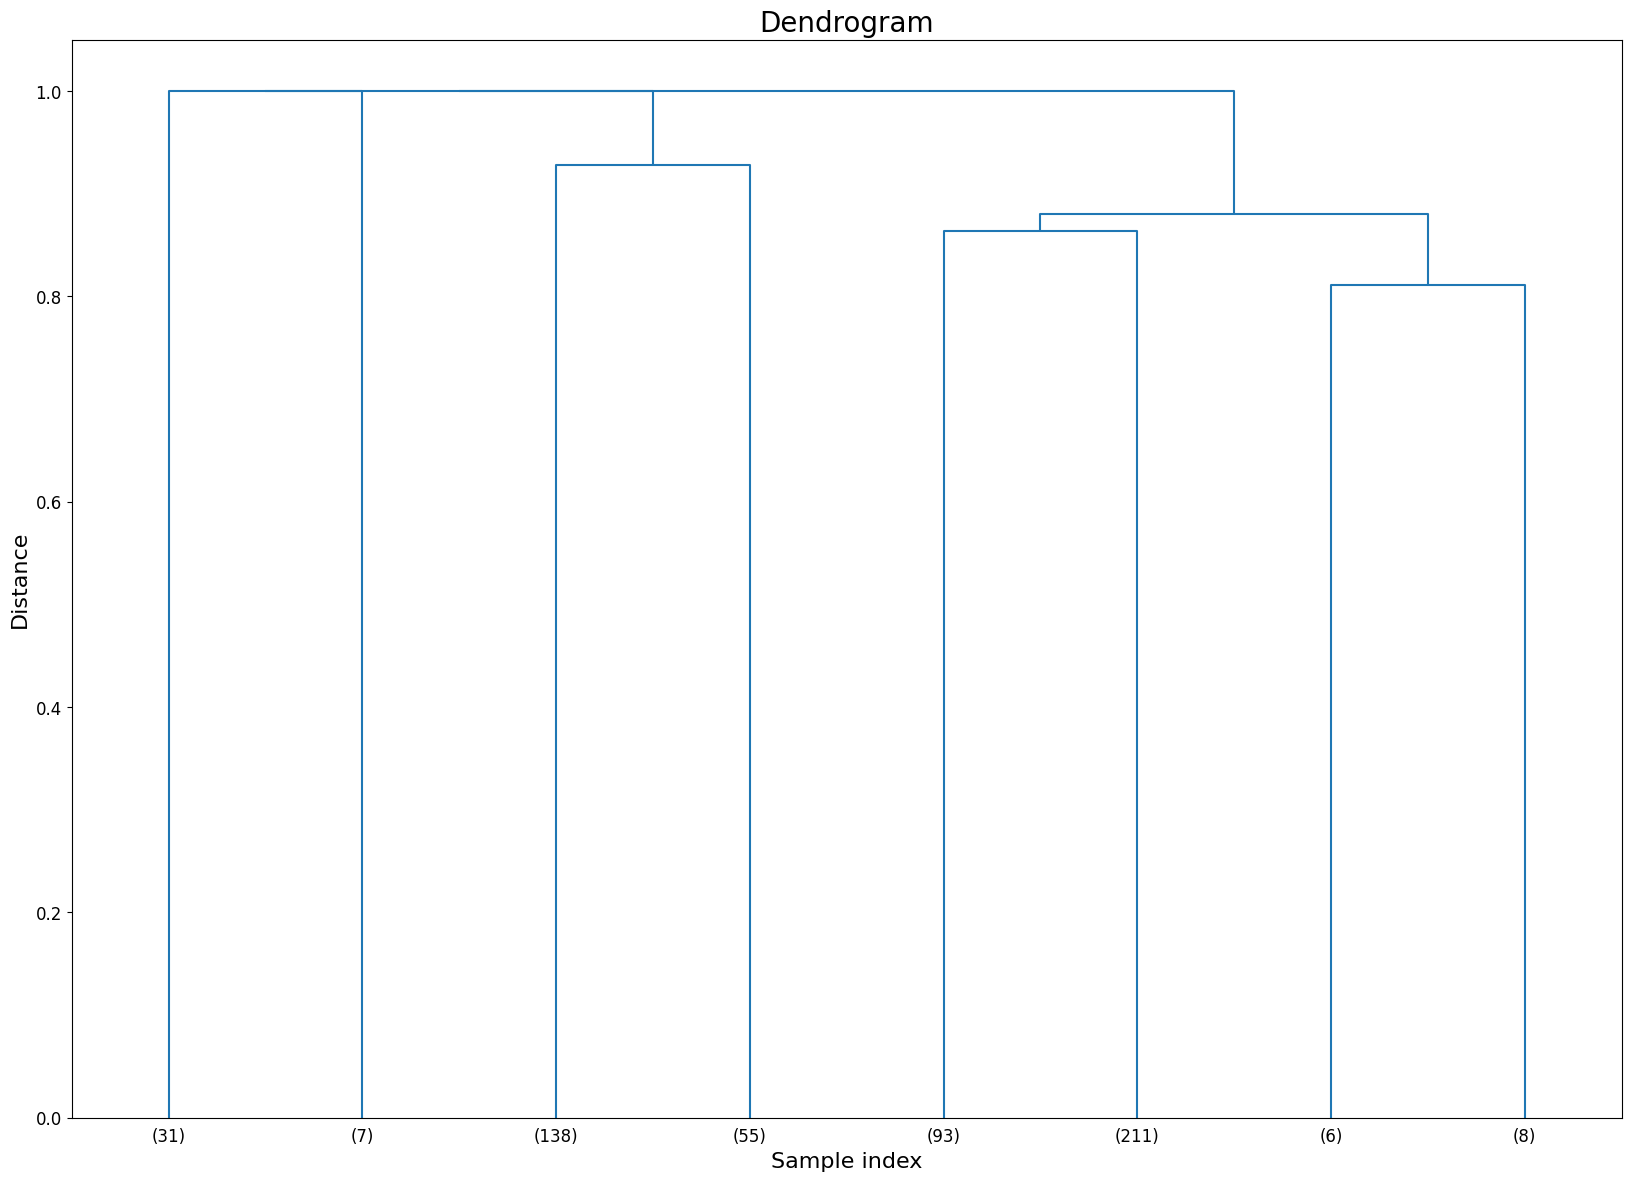

Silhouette score for maximum distance of 0.99: 0.21344898260052142


In [92]:
from scipy.cluster.hierarchy import dendrogram, fcluster
import matplotlib.pyplot as plt

# Plot the dendrogram with truncate_mode to see the cuts at different levels
plt.figure(figsize=(20, 14))
dn = dendrogram(linked,
                orientation='top',
                labels=[name for name in unique_adv],
                distance_sort='descending',
                show_leaf_counts=True,
                get_leaves=True,
                truncate_mode='level',  # Show only the top levels of the dendrogram
                p=2)  # Number of levels to show

plt.title('Dendrogram', fontsize=20)
plt.xlabel('Sample index', fontsize=16)
plt.ylabel('Distance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Extract clusters at different levels
max_d = 0.99 # Set the maximum distance threshold for clustering
clusters = fcluster(linked, max_d, criterion='distance')
sil_coeff = silhouette_score(X, clusters, metric='cosine')
print(f"Silhouette score for maximum distance of {max_d}: {sil_coeff}")
# Print the clusters
# for cluster_id in set(clusters):
#     cluster_elements = [unique_adv[i] for i in range(len(clusters)) if clusters[i] == cluster_id]
#     print(f"Cluster {cluster_id}, {len(cluster_elements)}: {cluster_elements}")

In [57]:
from scipy.cluster.hierarchy import to_tree

def get_root_nodes_with_elements(linkage_matrix, labels):
    """Get the root nodes at each level of the hierarchical clustering tree with elements."""
    root, nodes = to_tree(linkage_matrix, rd=True)
    levels = {}

    def traverse(node, level=0):
        if level not in levels:
            levels[level] = []
        elements = node.pre_order(lambda x: labels[x.id] if x.is_leaf() else None)
        elements = [e for e in elements if e is not None]  # Filter out None values
        levels[level].append((node, elements))
        if not node.is_leaf():
            traverse(node.left, level + 1)
            traverse(node.right, level + 1)

    traverse(root)
    return levels

# Get the root nodes at each level with elements
root_nodes_with_elements = get_root_nodes_with_elements(linked, unique_adv)

# Print the root nodes at each level with elements
for level, nodes in root_nodes_with_elements.items():
    print(f"Level {level}:")
    for node, elements in nodes:
        print(f"  Node ID: {node.id}, Count: {node.count}, Elements: {elements}")

Level 0:
  Node ID: 1096, Count: 549, Elements: ['jusque', 'religieusement', 'implicitement', 'dessous', 'par-dessous', 'météorologiquement', 'sexuellement', 'thermodynamiquement', 'bis', 'environ', 'quelque', 'e.g.', 'mi', 'ter', 'en-dessous', 'vis-à-vis', 'hors-catégorie', 'durant', 'dessus-dessous', 'ci-après', 'quoique', 'perpendiculairement', 'penta-', 'cep.', 'secondairement', 'déca-', 'soit', 'tantôt', 'pseudo', 'par-dessus', 'méga', 'inconsciemment', 'i.e.', 'naguère', 'proportionnellement', 'usque', 'littéralement', 'N.B', 'assurément', 'postérieurement', 'accessoirement', 'physiologiquement', 'globalement', 'que', 'non', 'ne', 'pas', 'jamais', 'symboliquement', 'spécifiquement', 'fondamentalement', 'résolument', 'purement', 'logiquement', 'autrefois', 'jadis', 'vraisemblablement', 'anciennement', 'fort', 'nettement', 'presque', 'juste', 'tout', 'peu', 'plus', 'même', 'seulement', 'institutionnellement', 'délicieusement', 'faussement', 'hyper', 'trés', 'mutuellement', 'ultra',

In [34]:
class GrexQuery:
    def __init__(self, scope: str, conclusion: str = None, meta_conclusion: str = None):
        if conclusion is None and meta_conclusion is None:
            raise ValueError("At least one conclusion must be provided.")
        self.scope = scope
        self.conclusion = conclusion
        self.meta_conclusion = meta_conclusion

def get_clusters(linkage_matrix, mapping=None):
    """Explore the linked tree and extract all clusters"""
    _, cluster_nodes = to_tree(linkage_matrix, rd=True)
    clusters = list()
    for node in cluster_nodes:
        if not node.is_leaf():
            right_children_features = tuple(node.right.pre_order(lambda x: mapping[x.id] if mapping else x.id))
            left_children_features = tuple(node.left.pre_order(lambda x: mapping[x.id] if mapping else x.id))
            clusters.append((right_children_features, left_children_features))
    return clusters

adv_clusters = get_clusters(linked, idx2adv)

# scopes and conclusions
queries = [GrexQuery("|".join(cluster[0]) + "|" + "|".join(cluster[1]), "|".join(cluster[1])) for cluster in adv_clusters]

In [38]:
for c in adv_clusters:
    print(c)

(('assurément',), ('N.B',))
(('faussement',), ('délicieusement',))
(('hyper',), ('délicieusement', 'faussement'))
(('délicieusement', 'faussement', 'hyper'), ('institutionnellement',))
(('ultra',), ('mutuellement',))
(('sauvagement',), ('librement',))
(('affreusement',), ('copieusement',))
(('copieusement', 'affreusement'), ('doublement',))
(('illégalement',), ('doublement', 'copieusement', 'affreusement'))
(('doublement', 'copieusement', 'affreusement', 'illégalement'), ('injustement',))
(('minutieusement',), ('injustement', 'doublement', 'copieusement', 'affreusement', 'illégalement'))
(('injustement', 'doublement', 'copieusement', 'affreusement', 'illégalement', 'minutieusement'), ('mondialement',))
(('nouvellement',), ('mondialement', 'injustement', 'doublement', 'copieusement', 'affreusement', 'illégalement', 'minutieusement'))
(('mondialement', 'injustement', 'doublement', 'copieusement', 'affreusement', 'illégalement', 'minutieusement', 'nouvellement'), ('perpétuellement',))
(('

In [36]:
queries[3].scope, queries[3].conclusion

('délicieusement|faussement|hyper|institutionnellement',
 'institutionnellement')

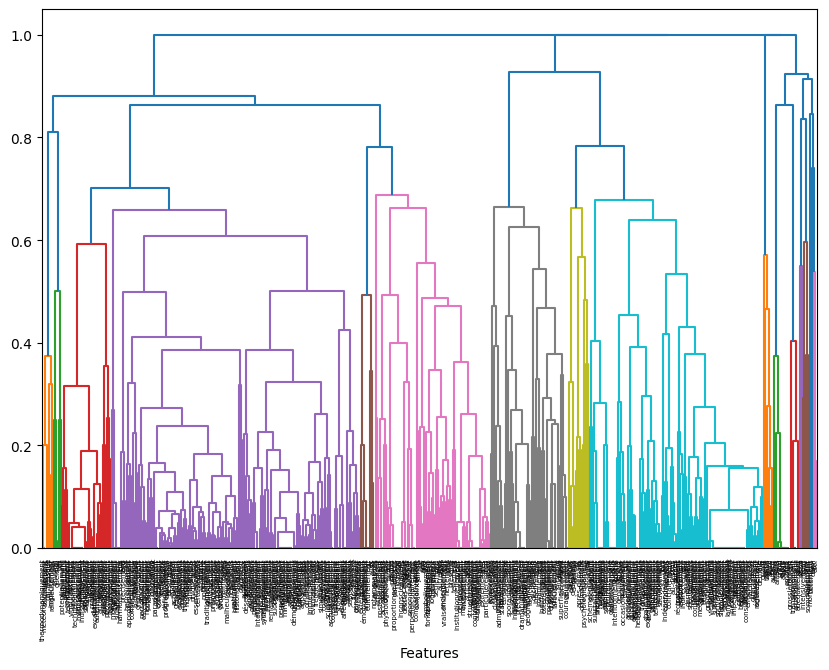

In [40]:
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # a linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, labels=[name for name in unique_adv], **kwargs)

agglo = AgglomerativeClustering(compute_distances=True, linkage="complete", metric="cosine")
agglo.fit(X)

plt.figure(figsize=(10, 7))
plot_dendrogram(agglo)
plt.xlabel("Features")
plt.show()